In [152]:
import sys
sys.path.append('../Segmentation_ObjectDetection/yolov7_mask/')
sys.path.append('../Segmentation_ObjectDetection/detectron2/')

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
import torch
import cv2
import yaml
from torchvision import transforms
import numpy as np

from utils.datasets import letterbox
from utils.general import non_max_suppression_mask_conf

from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.layers import paste_masks_in_image


In [153]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open('yolov7_mask/data/hyp.scratch.mask.yaml') as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load('yolov7_mask/yolov7-mask.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

In [154]:
image = cv2.imread('data/dataset_firstTest/test/images/000000071226.jpg')  # 504x378 image  #'yolov7_mask/inference/images/horses.jpg'
# image = cv2.imread('PHOTO-2018-05-15-12-29-23.jpg') 
image = letterbox(image, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

output = model(image)

torch.Size([1, 3, 448, 640]) False


c:\Users\DannW\Anaconda3\envs\yolov7_env\lib\site-packages\torch\nn\functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [155]:
image.shape

torch.Size([1, 3, 448, 640])

In [156]:
output.keys()

dict_keys(['mask_iou', 'test', 'attn', 'bbox_and_cls', 'bases', 'sem'])

In [157]:
inf_out, train_out, attn, mask_iou, bases, sem_output = output['test'], output['bbox_and_cls'], output['attn'], output['mask_iou'], output['bases'], output['sem']

In [158]:
inf_out.shape, train_out[0].shape, train_out[1].shape, train_out[2].shape, attn.shape, mask_iou, bases.shape, sem_output.shape

(torch.Size([1, 17640, 85]),
 torch.Size([1, 3, 56, 80, 85]),
 torch.Size([1, 3, 28, 40, 85]),
 torch.Size([1, 3, 14, 20, 85]),
 torch.Size([1, 17640, 980]),
 None,
 torch.Size([1, 4, 112, 160]),
 torch.Size([1, 1, 112, 160]))

In [159]:
bases = torch.cat([bases, sem_output], dim=1)
nb, _, height, width = image.shape
names = model.names
pooler_scale = model.pooler_scale
pooler = ROIPooler(output_size=hyp['mask_resolution'], scales=(pooler_scale,), sampling_ratio=1, pooler_type='ROIAlignV2', canonical_level=2)

In [171]:
names[15]

'cat'

In [161]:
output, output_mask, output_mask_score, output_ac, output_ab = non_max_suppression_mask_conf(inf_out, attn, bases, pooler, hyp, conf_thres=0.25, iou_thres=0.65, merge=False, mask_iou=None)

In [162]:
output[0], output_mask[0].shape, output_mask_score, output_ac, output_ab

(tensor([[7.18125e+01, 6.48125e+01, 2.28688e+02, 2.28438e+02, 8.95069e-01, 1.60000e+01],
         [3.13062e+02, 7.05938e+01, 4.66938e+02, 1.42156e+02, 7.75644e-01, 1.50000e+01],
         [3.00000e+00, 2.82500e+01, 6.35000e+02, 4.33250e+02, 7.26471e-01, 5.90000e+01],
         [1.89000e+02, 1.51750e+02, 5.26000e+02, 4.28250e+02, 6.66634e-01, 1.60000e+01],
         [4.11250e+01, 2.35625e+02, 1.19375e+02, 3.19875e+02, 6.34800e-01, 7.30000e+01],
         [3.13875e+02, 7.01250e+01, 4.68625e+02, 1.42125e+02, 2.77107e-01, 1.60000e+01]], device='cuda:0'),
 torch.Size([6, 3136]),
 [tensor([[0.96240],
          [0.94873],
          [0.96338],
          [0.96191],
          [0.95361],
          [0.94092]], device='cuda:0', dtype=torch.float16)],
 [[]],
 [[]])

In [163]:
output[0][:, :4]

tensor([[ 71.81250,  64.81250, 228.68750, 228.43750],
        [313.06250,  70.59375, 466.93750, 142.15625],
        [  3.00000,  28.25000, 635.00000, 433.25000],
        [189.00000, 151.75000, 526.00000, 428.25000],
        [ 41.12500, 235.62500, 119.37500, 319.87500],
        [313.87500,  70.12500, 468.62500, 142.12500]], device='cuda:0')

In [164]:
pred, pred_masks = output[0], output_mask[0]
base = bases[0]
bboxes = Boxes(pred[:, :4])
original_pred_masks = pred_masks.view(-1, hyp['mask_resolution'], hyp['mask_resolution'])
pred_masks = retry_if_cuda_oom(paste_masks_in_image)(original_pred_masks, bboxes, (height, width), threshold=0.5)
pred_masks_np = pred_masks.detach().cpu().numpy()
pred_cls = pred[:, 5].detach().cpu().numpy()
pred_conf = pred[:, 4].detach().cpu().numpy()
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)
pnimg = nimg.copy()

C:\Users\DannW\AppData\Local\Temp\ipykernel_23176\618469625.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)


In [165]:
bboxes

Boxes(tensor([[ 71.81250,  64.81250, 228.68750, 228.43750],
        [313.06250,  70.59375, 466.93750, 142.15625],
        [  3.00000,  28.25000, 635.00000, 433.25000],
        [189.00000, 151.75000, 526.00000, 428.25000],
        [ 41.12500, 235.62500, 119.37500, 319.87500],
        [313.87500,  70.12500, 468.62500, 142.12500]], device='cuda:0'))

In [166]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue
    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]             
    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
    label = '%s %.3f' % (names[int(cls)], conf)
    t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
    c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
    pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)  # filled
    pnimg = cv2.putText(pnimg, label, (bbox[0], bbox[1] - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)  
                     

In [167]:
pnimg.shape

(448, 640, 3)

In [168]:
from PIL import Image
imgcustom = Image.fromarray(pnimg)

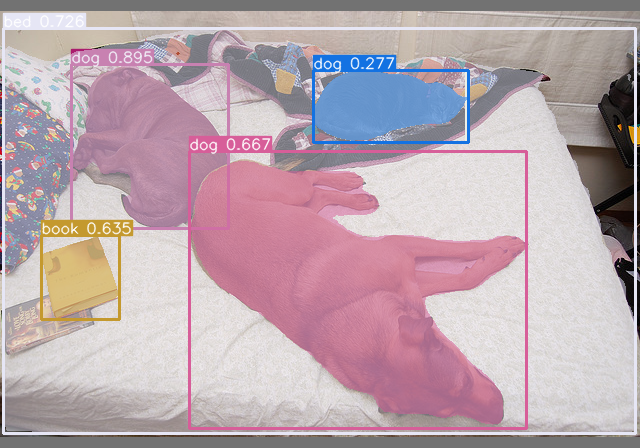

In [169]:
imgcustom